# Übung: Auswertung einer Zeitreihe

## Beisipiel Klimawandel

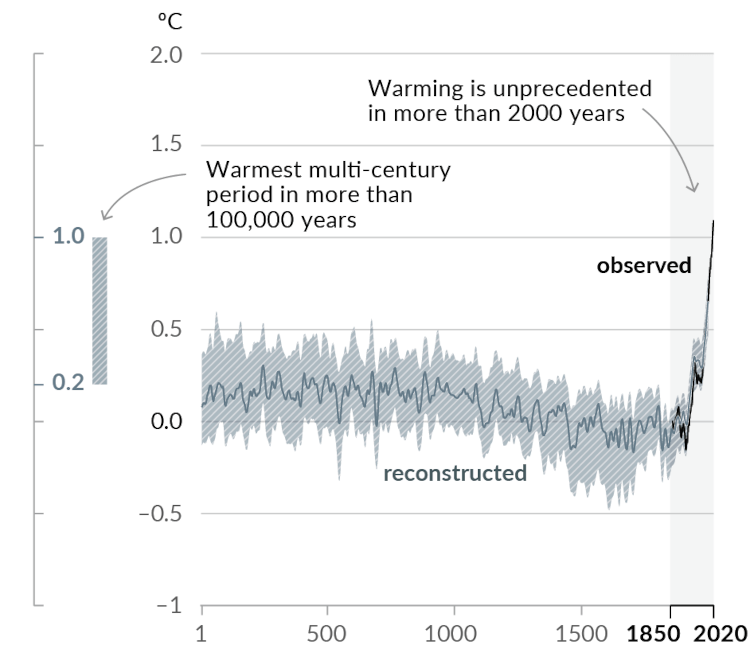
Quelle: https://www.ipcc.ch/report/ar6/wg1/figures/summary-for-policymakers/figure-spm-1/

Klimaänderungen vollziehen sich üblicherweie innerhalb von Jahrtausenden. Im Augenblick sieht es so aus, als erlebten wir eine Änderung innerhalb weniger Menschengenerationen. Die beobachtete Temperaturerhöhung korreliert mit der CO2-Konzentration. Das beweist keine Kausalität. Bemerkenswert ist aber, dass ein Spurengas wie CO2 in Simulationsrechnungen genau zu dem beobachteten Ergebnis führt. 

In der Übungsstudie sollen einige Fakten aus der CO2-Konzentrationskurve abgeleitet werden.

## Annahmen:

1. Es gelte die unten genannte Funktion T(CO2), die die Globaltemperaturveränderung in Abhängigkeit von der CO2-Konzentration beschreibt.
2. Die Messdaten der CO2-Konzentration sind valde.

## Aufgabe:

* Wie hoch ist aktuell die jährliche Zunahme der CO2 Konzentration in Einheiten von *ppm/Jahr*?
* Wie entwickelt sich die CO2-Konzentration in der Atmsphäre in den letzten Jahren im Vergleich zu den 1960er Jahren?
* Wie hoch wäre heute die CO2-Konzentration, wenn sich die Zunahme im Zeitraum von 1960 bis 1980 linear entwickelt hätte?
* Wie hoch ist vermutlich die CO2-Konzentration in den Jahren 2050, 2080, 2100 und 2150?
* Welche Temperaturerhöhungen lassen sich diesen Konzentrationen zuordnen?

## Zusatzaufgabe: Abschätzen der Größenordnngen

* In welcher Größenordnung liegt die Dekarbonisierungsleistung der Vegetation auf der Erde (Tipp: Feinstruktur in der CO2-Kurve)?
* Vergleichen Sie damit die Überlegungen, CO2 aus der Verbrennung zu speichern. Wie viele Tonnen CO2 müsste man speichern, um den CO2 Anstieg aufzufangen?
* Korreliert die Menge der CO2 Zunahme mit der Menge verfeuerter fossiler Brennstoffe?

Hinweise:
  
* Die Gasmenge der Atmosphäre ist bekannt. Darüber lässt sich die Masse von 400 ppm CO2 abschätzen (s.a. https://hogback.atmos.colostate.edu/group/dave/pdf/ppmv.pdf): Gesamtmasse des CO2 in der Atmosphäre: ca 3e15 kg. 1ppm wiegt demnach (1/400) etwas weniger als 1e13 kg (unter der Vereinfachung einheitlicher Atommassen der Moleküle):
    * 1ppm CO2 == 10 Gt (Korrekter Wert: um 8 Gt)
* Fossile Energieträger.
    * Wie viel CO2 erzeugt die Verfeuerung von Öl weltweit? Hinweis: 0.5 kg Benzin setzen 1 kg CO2 frei.
    * Wie sieht es bei Kohle aus? Hinweis: 1kg Kohle setzen 3 kg CO2 frei.
    * Torf: ?
    * Gas: ?


## Hinweise

## 1. Relation between CO2-concentration and temperature

[How are CO₂ concentrations related to warming?](https://factsonclimate.org/infographics/concentration-warming-relationship)

https://factsonclimate.org/infographics/concentration-warming-relationship

&nbsp;

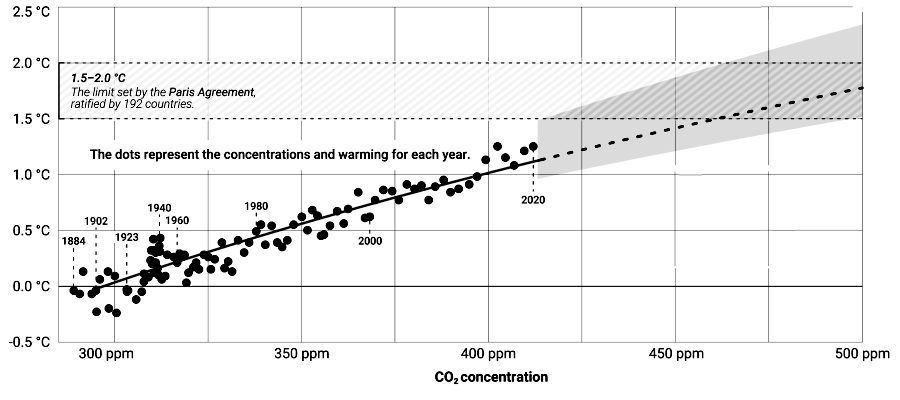


$$
\Delta T(c) = S \cdot \log_2 (\frac{c}{c_0})
$$

* S =
    * 2...3.1 K: if log_2
    * 2.9 ... 4.5 K: if log_e
* $\Delta T(c)$ = 0 for $c_0 = 300 ppm$ (year 1910)

In [2]:
%reset -f

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def deltat(c, c0=300, S = 2.37):
    return math.log(c/c0,2)* S

deltatv = np.vectorize(deltat)

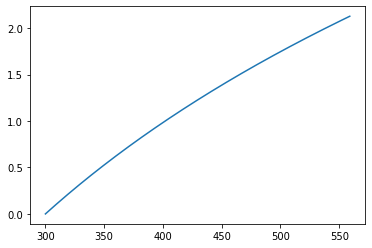

In [3]:
x = np.arange(300,560)

#for c in range(300, 500):
y = deltatv(x)

plt.plot(x,y)
plt.show()

## 2. Measurement data on CO2 concentration


### Get data: 1958 .. 2023 

* https://www.co2.earth/co2-datasets
    * https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/daily/daily_in_situ_co2_mlo.csv

In [4]:
#fn = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/daily/daily_in_situ_co2_mlo.csv'
fn = 'data/daily_in_situ_co2_mlo.zip' # till 2023

df = pd.read_csv(fn, sep='[, ]+', engine="python", comment='%', header=None,
                 na_values='NaN',
                 names =  ['year', 'month', 'day', 'cc', 'nb', 'scale', 'sta']                 
                )
df.index = pd.to_datetime(df[['year', 'month', 'day']])
df = df[['cc']]
df

,cc
1958-01-01,NaN
1958-01-02,NaN
1958-01-03,NaN
1958-01-04,NaN
1958-01-05,NaN
...,...
2023-10-27,NaN
2023-10-28,NaN
2023-10-29,NaN
2023-10-30,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24045 entries, 1958-01-01 to 2023-10-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cc      17790 non-null  float64
dtypes: float64(1)
memory usage: 375.7 KB


<AxesSubplot:>

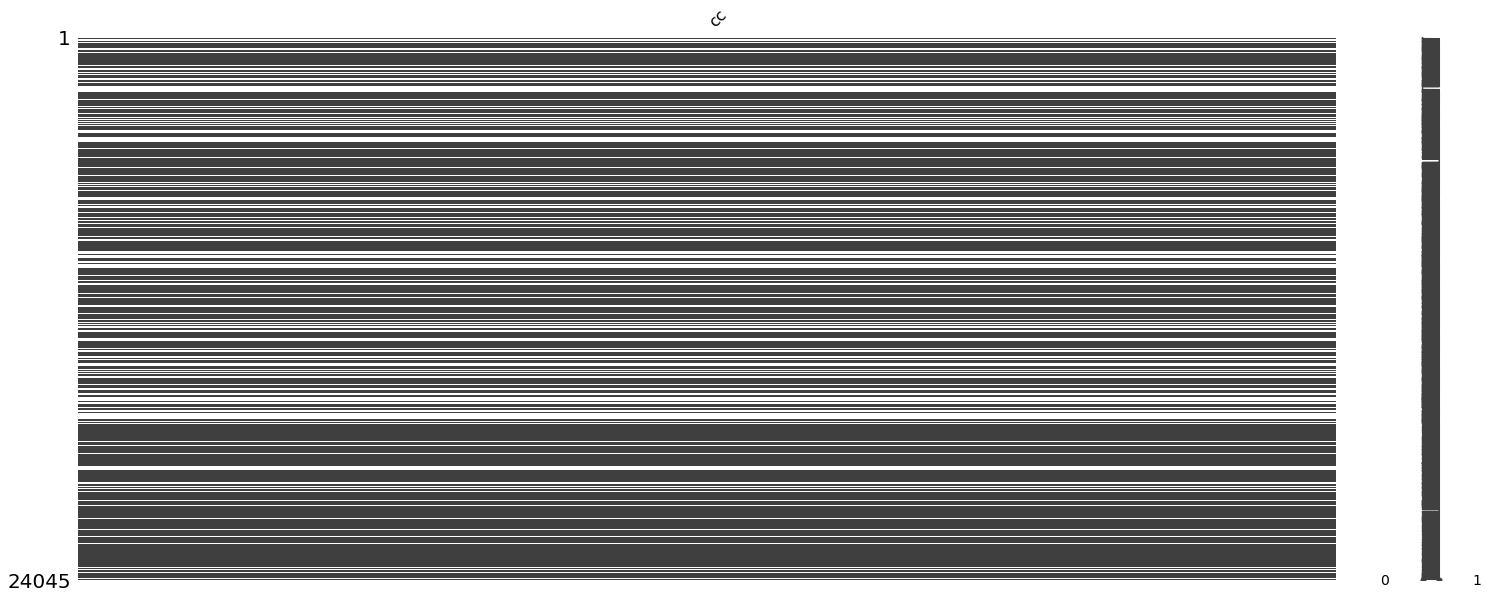

In [6]:
import missingno as msno
msno.matrix(df)


### Cleaning

1. Remove nan values (especially leading and trailing NaN).
2. `resample.mean` to week (or month?) instead of day: bridges small holes and guarantee periodicity -- but creates new NaN (why?).
3. `interpolate` which removes all NaN

In [7]:
dg = df.copy()
print(dg.shape)
print('nan: ', dg.isnull().sum())

(24045, 1)
nan:  cc    6255
dtype: int64


In [8]:
dg = df.dropna()
dg=dg.resample("w").agg('mean')
dg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3423 entries, 1958-03-30 to 2023-10-29
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cc      3283 non-null   float64
dtypes: float64(1)
memory usage: 53.5 KB


In [9]:
dg.interpolate(method="time", order=3, inplace=True)

In [10]:
#check NaN values; should be empty.
dg[dg['cc'].isnull()]
dg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3423 entries, 1958-03-30 to 2023-10-29
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cc      3423 non-null   float64
dtypes: float64(1)
memory usage: 53.5 KB


### Linear Regression

Play around with `sample_weight`. Tip:

~~~
wfactor = 1 #0 # 0 #0.5 # 1# -1
weight = (np.exp(x.astype(float)/1e17 * wfactor)).reshape(-1,)


model = LinearRegression()
...
~~~

In [11]:
from sklearn.linear_model import LinearRegression
import plotly_express as px

x = np.array(dg.index.to_numpy(), dtype=float).reshape(-1,1)
y = dg['cc']

wfactor = 1 #0 # 0 #0.5 # 1# -1
weight = (np.exp(x.astype(float)/1e17 * wfactor)).reshape(-1,)
# dg["date"] = dg.index
# df['day_of_year'] = df['date'].dt.dayofyear

model = LinearRegression().fit(x, y, sample_weight=weight)
y_pred = model.predict(x)
dg["predict"] = y_pred
px.scatter(dg)


## Extrapolate

Question: extrapolate to 2100

Linear regression was easy. 

Main problem now: how to hande datetime-numbers.



In [13]:
# try this:

extrapoint = '2100-12-31'
startpoint = "last date in dataset"
x_futd =  np.datetime64(extrapoint, 'ns')
x_fut = x_futd.astype(float).reshape(-1,1) 
y2100 = model.predict(x_fut)[0]
print(f'{extrapoint}: {y2100:6.1f} ppm')
df.loc[x_futd] = [y2100]
px.scatter(df)



2100-12-31:  602.8 ppm


2100-12-31:  592.4 ppm


<AxesSubplot:>

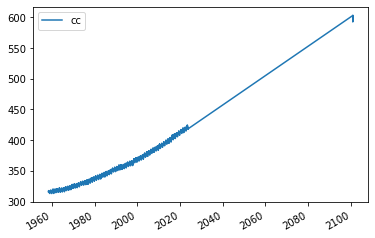

In [14]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Annahme: df ist dein DataFrame mit einem DateTime-Index und einer abhängigen Variable 'y'

df = df.dropna()
df=df.resample("w").agg('mean')
df.interpolate(method="time", order=3, inplace=True)

# Letztes Datum im Index des DataFrames finden
last_date_in_dataset = df.index.max()

# Endpunkt für die Extrapolation setzen
extrapoint = '2100-12-31'

# Umwandlung der Datumsangaben in np.datetime64-Objekte
x_last_date = np.datetime64(last_date_in_dataset, 'ns')
x_futd = np.datetime64(extrapoint, 'ns')

# Berechnung der Differenz in Nanosekunden zwischen dem letzten Datum im Index und dem Endpunkt
difference_ns = x_futd - x_last_date

# Vorbereitung der Daten für die lineare Regression
X = df.index.astype(np.int64).values.reshape(-1, 1)  # Unabhängige Variable
y = df['cc'].values  # Abhängige Variable

# Lineare Regression durchführen
model = LinearRegression()
model.fit(X, y)

# Extrapolation für den Endpunkt durchführen
x_fut = (x_last_date + difference_ns).astype(float).reshape(-1, 1)
y2100 = model.predict(x_fut)[0]

# Ausgabe des extrapolierten Werts
print(f'{extrapoint}: {y2100:6.1f} ppm')

# Hinzufügen des extrapolierten Werts zum DataFrame
df.loc[x_futd] = [y2100]

# Plot des DataFrames
df.plot()


In [15]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression


# Annahme: df ist dein DataFrame mit einem DateTime-Index und einer abhängigen Variable 'y'

# Vorletztes Datum im Index des DataFrames finden
second_last_date_in_dataset = df.index[-2]

# Endpunkt für die Extrapolation setzen
extrapoint = '2100-12-31'

# Umwandlung der Datumsangaben in np.datetime64-Objekte
x_second_last_date = np.datetime64(second_last_date_in_dataset, 'ns')
x_futd = np.datetime64(extrapoint, 'ns')

# Berechnung der Differenz in Nanosekunden zwischen dem vorletzten Datum im Index und dem Endpunkt
difference_ns = x_futd - x_second_last_date

# Vorbereitung der Daten für die lineare Regression
X = df.index[:-1].astype(np.int64).values.reshape(-1, 1)  # Unabhängige Variable ohne das letzte Datum
y = df['cc'].values[:-1]  # Abhängige Variable ohne den letzten Wert

# Lineare Regression durchführen
model = LinearRegression()
model.fit(X, y)

# Extrapolation für den Endpunkt durchführen
x_fut = (x_second_last_date + difference_ns).astype(float).reshape(-1, 1)
y2100 = model.predict(x_fut)[0]

# Ausgabe des extrapolierten Werts
print(f'{extrapoint}: {y2100:6.1f} ppm')

# Hinzufügen des extrapolierten Werts zum DataFrame
df.loc[x_futd] = [y2100]

# Plot des DataFrames
px.scatter(df)


2100-12-31:  592.4 ppm
